# Introduction

---

Plotting the daily energy production supply and demand in CAISO. The data is from the California Independent System Operator (CAISO) and is available on the [CAISO Open Access Same-Time Information System (OASIS)](http://oasis.caiso.com/mrioasis/).

In [1]:
import pandas as pd
import numpy as np
import datetime
from dataclasses import dataclass
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df_renewable = pd.read_csv(
    '../data/CAISO-renewables-20240427.csv',
    na_filter=False,
    index_col=0,
    delimiter=',',
).T

In [3]:
df_supply = pd.read_csv(
    '../data/CAISO-supply-20240427.csv',
    na_filter=False,
    index_col=0,
).T.iloc[:-1]
df_supply["Solar"] = df_renewable["Solar"].values
df_supply["Wind"] = df_renewable["Wind"].values
df_supply["Date"] = df_supply.columns.name.split(' ')[-1] 
df_supply.rename_axis('Supply', axis='columns', inplace=True)
df_supply.index.name = 'Time'
df_supply.reset_index(inplace=True)
df_supply["Date Time"] = pd.DataFrame(
    df_supply["Date"] + ' ' + df_supply["Time"]
)
df_supply["Date Time"] = pd.to_datetime(df_supply["Date Time"])
df_supply.set_index('Date Time', inplace=True)
df_supply.drop(columns=["Date", "Time"], inplace=True)

df_demand = df_renewable["Demand"]
df_demand.index = df_supply.index

In [4]:
df = pd.concat([df_supply, df_demand], axis=1, keys=['Supply', 'Demand'])


In [5]:
# Plotly line plots for Supply and Demand
# Supply plots are stacked

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Nuclear'], mode='lines', name='Nuclear'))
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Large hydro'], mode='lines', name='Hydro'))
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Solar'], mode='lines', name='Solar'))
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Wind'], mode='lines', name='Wind'))
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Natural gas'], mode='lines', name='Gas'))
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Imports'], mode='lines', name='Imports'))
fig.add_trace(go.Scatter(x=df.index, y=df['Supply']['Batteries'], mode='lines', name='Batteries'))
fig.add_trace(go.Scatter(x=df.index, y=df['Demand']['Demand'], mode='lines', name='Demand'))
fig.update_layout(title='CAISO Supply and Demand',
    xaxis_title='Time',
    yaxis_title='MW',
    legend_title='Legend',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    height=800,
    width=1200,
)


/var/folders/_f/vgm31s3n7wq3qmcm2xdk63q80000gn/T/ipykernel_36270/3809823461.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



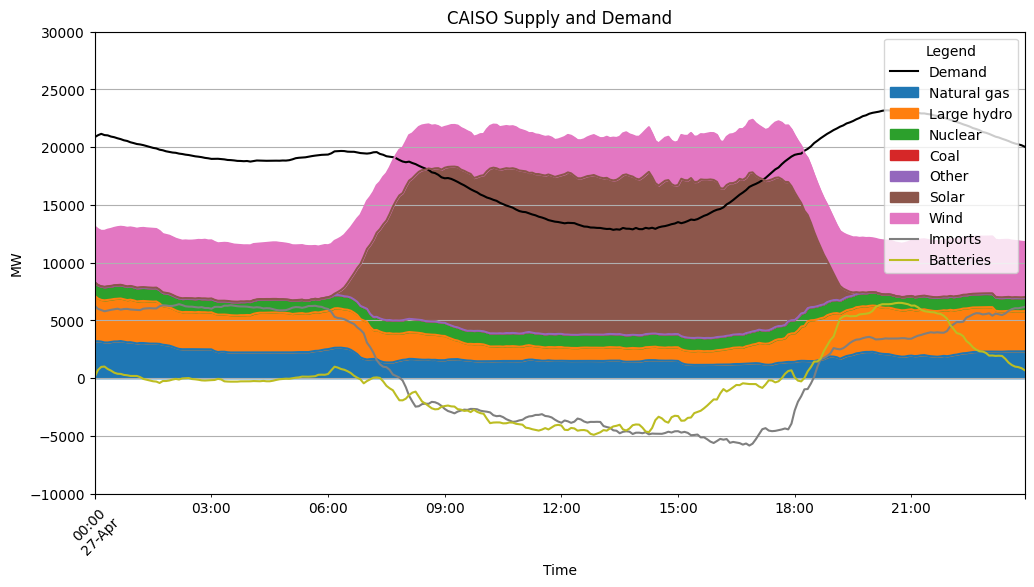

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

df["Demand"].plot(ax=ax, color='black', label='Demand')

# stack the supply columns except import and batteries
df["Supply"].drop(columns=["Imports", "Batteries", "Renewables"]).plot.area(ax=ax, stacked=True)

# plot the import and battery columns
df["Supply"][["Imports", "Batteries"]].plot(ax=ax)

ax.set_title('CAISO Supply and Demand')
ax.set_xlabel('Time')
ax.set_ylabel('MW')
ax.set_ylim(-10000, 30000)
ax.legend(title='Legend')
ax.grid(True)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)



# Optimize the energy cost

---

Using Mixed Integer Linear Programming (MILP) to optimize the energy cost. The objective is to minimize the total cost of energy production while satisfying the demand. The constraints are the energy production capacity and the energy demand.

In [7]:
df_ = pd.DataFrame()
# Assuming df.index is of type datetime
df_['time'] = df.index.time

# Convert time to timedelta
df_['time_delta'] = df_['time'].apply(lambda t: datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second))

# Now you can perform operations on 'time_delta' column
df.loc[:, ("Misc", "Interval [s]")] = df_['time_delta'].dt.total_seconds().diff(periods=1).fillna(0).values

In [8]:
np.ceil(df.index[11].time().minute / 5).astype(int)

11

<Axes: xlabel='Date Time'>

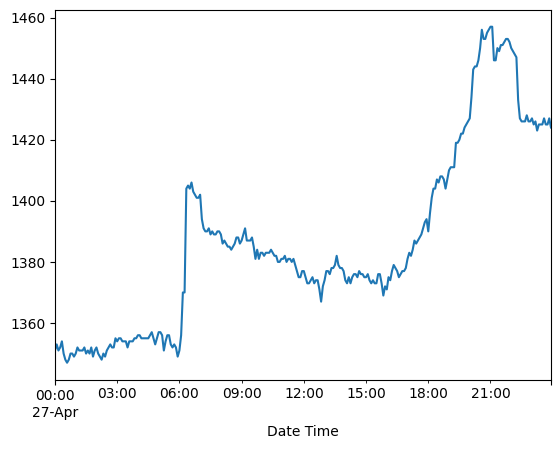

In [9]:
(df["Supply"]["Renewables"] - df["Supply"]["Solar"] - df["Supply"]["Wind"]).plot()

In [10]:
import gurobipy
from gurobipy import GRB

In [11]:
df["Supply"].columns
df.index.values

array(['2024-04-27T00:00:00.000000000', '2024-04-27T00:05:00.000000000',
       '2024-04-27T00:10:00.000000000', '2024-04-27T00:15:00.000000000',
       '2024-04-27T00:20:00.000000000', '2024-04-27T00:25:00.000000000',
       '2024-04-27T00:30:00.000000000', '2024-04-27T00:35:00.000000000',
       '2024-04-27T00:40:00.000000000', '2024-04-27T00:45:00.000000000',
       '2024-04-27T00:50:00.000000000', '2024-04-27T00:55:00.000000000',
       '2024-04-27T01:00:00.000000000', '2024-04-27T01:05:00.000000000',
       '2024-04-27T01:10:00.000000000', '2024-04-27T01:15:00.000000000',
       '2024-04-27T01:20:00.000000000', '2024-04-27T01:25:00.000000000',
       '2024-04-27T01:30:00.000000000', '2024-04-27T01:35:00.000000000',
       '2024-04-27T01:40:00.000000000', '2024-04-27T01:45:00.000000000',
       '2024-04-27T01:50:00.000000000', '2024-04-27T01:55:00.000000000',
       '2024-04-27T02:00:00.000000000', '2024-04-27T02:05:00.000000000',
       '2024-04-27T02:10:00.000000000', '2024-04-27

In [12]:
@dataclass
class Data:
    time = list(df.index.values)
    energies = [
        'Solar',
        'Wind',
        'Nuclear',
        'Natural gas',
        'Coal',
        'Other',
        'Large Hydro',
        'Other Renewables',
        'Imports',
    ]
    production_cost = {
        'Solar': 0,
        'Wind': 0,
        'Nuclear': 0.30,
        'Natural gas': 0.10,
        'Coal': 0.10,
        'Other': 0.10,
        'Large Hydro': 0.60,
        'Other Renewables': 0.70,
        'Imports': 0.90,
    }

In [13]:
# Model

model = gurobipy.Model("Energy Optimization")

Restricted license - for non-production use only - expires 2025-11-24


In [14]:
# Variables

Data.time

[numpy.datetime64('2024-04-27T00:00:00.000000000'),
 numpy.datetime64('2024-04-27T00:05:00.000000000'),
 numpy.datetime64('2024-04-27T00:10:00.000000000'),
 numpy.datetime64('2024-04-27T00:15:00.000000000'),
 numpy.datetime64('2024-04-27T00:20:00.000000000'),
 numpy.datetime64('2024-04-27T00:25:00.000000000'),
 numpy.datetime64('2024-04-27T00:30:00.000000000'),
 numpy.datetime64('2024-04-27T00:35:00.000000000'),
 numpy.datetime64('2024-04-27T00:40:00.000000000'),
 numpy.datetime64('2024-04-27T00:45:00.000000000'),
 numpy.datetime64('2024-04-27T00:50:00.000000000'),
 numpy.datetime64('2024-04-27T00:55:00.000000000'),
 numpy.datetime64('2024-04-27T01:00:00.000000000'),
 numpy.datetime64('2024-04-27T01:05:00.000000000'),
 numpy.datetime64('2024-04-27T01:10:00.000000000'),
 numpy.datetime64('2024-04-27T01:15:00.000000000'),
 numpy.datetime64('2024-04-27T01:20:00.000000000'),
 numpy.datetime64('2024-04-27T01:25:00.000000000'),
 numpy.datetime64('2024-04-27T01:30:00.000000000'),
 numpy.datet